In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp

ds_name = 'TB'
ds_folder = f'/mnt/data2/chaoyue/data/cleaned_data'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/mnt/data2/chaoyue/data/cleaned_data/cleaned_resp_edge.csv
/mnt/data2/chaoyue/data/cleaned_data/cleaned_TB_node.csv
/mnt/data2/chaoyue/data/cleaned_data/cleaned_TB_edge.csv
/mnt/data2/chaoyue/data/cleaned_data/cleaned_resp_node.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
#import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
%matplotlib inline

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [3]:
#Import the files
node_df = pd.read_csv(f'{ds_folder}/cleaned_{ds_name}_node.csv')
edge_df = pd.read_csv(f'{ds_folder}/cleaned_{ds_name}_edge.csv')

In [4]:
node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node
0,10000.0,Background,A,static,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,3.0
1,10000.0,Background,A,static,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-23,1.0
2,10000.0,Background,A,static,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-30,2.0
3,10000.0,Background,A,static,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,4.0
4,10000.0,Background,A,static,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-03-09,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20678373,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-05,791.0
20678374,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-17,991.0
20678375,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-17,1139.0
20678376,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-01,2925.0


In [5]:
print('Shape of node data is', node_df.shape)
print ('Shape of edge data is', edge_df.shape)

Shape of node data is (20678378, 21)
Shape of edge data is (20671955, 5)


### Count number of trees

In [6]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 6423


In [7]:
#information about the node data set
node_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20678378 entries, 0 to 20678377
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   sim                   float64
 1   cluster_id            object 
 2   state                 object 
 3   dynamic               object 
 4   dynamic_rparam        float64
 5   v_sampling_fraction   float64
 6   v_cluster_size        float64
 7   v_fraction_state      float64
 8   v_timespan            float64
 9   gamma                 float64
 10  oster                 float64
 11  PD                    float64
 12  R0                    float64
 13  abs_growth_rate       float64
 14  fraction_time_growth  float64
 15  r_max                 float64
 16  ltt_shape             object 
 17  cherries              float64
 18  BLD                   float64
 19  date                  object 
 20  node                  float64
dtypes: float64(16), object(5)
memory usage: 3.2+ GB


In [8]:
node_df.describe()

,sim,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,node
count,2.067838e+07,2.067838e+07,2.067838e+07,2.067838e+07,2.067838e+07,2.067838e+07,2.067838e+07,2.067838e+07,2.067838e+07,2.067838e+07,2.067838e+07,2.067838e+07,2.067838e+07,2.067838e+07,2.067838e+07,2.067838e+07
mean,5.010861e+03,1.414203e-05,1.390646e+03,1.424594e+03,9.999964e-01,1.678595e+02,inf,1.678617e+02,2.413664e+04,6.313900e-02,3.956696e+02,4.906801e-01,8.151418e+03,2.770396e-01,8.324419e-01,1.662032e+03
std,2.894437e+03,6.473606e-05,5.164163e+02,4.420211e+02,2.128009e-04,4.115164e+01,NaN,4.115024e+01,8.706912e+03,3.958943e+00,8.451811e+04,2.954787e-01,7.964676e+03,1.389575e-02,1.184699e+00,9.799141e+02
min,1.000000e+00,0.000000e+00,5.011335e-02,6.000000e+00,9.565217e-01,1.400000e+01,-1.444014e+04,1.402695e+01,1.130000e+02,-6.549541e+01,6.309800e-01,0.000000e+00,2.839220e+00,1.000000e-01,-4.100000e+01,1.000000e+00
25%,2.487000e+03,0.000000e+00,1.569920e+03,1.570000e+03,1.000000e+00,1.560000e+02,-1.035013e+02,1.560021e+02,2.541900e+04,-7.668705e-01,9.629362e+01,2.325581e-01,6.236206e+03,2.722153e-01,0.000000e+00,8.120000e+02
50%,5.008000e+03,0.000000e+00,1.591840e+03,1.592000e+03,1.000000e+00,1.740000e+02,-9.034678e+01,1.740017e+02,2.719000e+04,8.783160e-01,1.302528e+02,4.947368e-01,8.326774e+03,2.772087e-01,1.000000e+00,1.643000e+03
75%,7.504000e+03,0.000000e+00,1.611040e+03,1.611000e+03,1.000000e+00,1.920000e+02,-2.074198e+01,1.920016e+02,2.857000e+04,2.184907e+00,1.686073e+02,7.444444e-01,1.048966e+04,2.822124e-01,1.500000e+00,2.500000e+03
max,1.000000e+04,5.221138e-04,1.656480e+03,3.184000e+03,1.000000e+00,2.370000e+02,inf,2.370012e+02,3.246100e+04,8.187527e+00,5.829878e+07,1.000000e+00,2.443693e+06,4.583333e-01,1.400000e+01,3.900000e+03


In [9]:
# change the dynamic of background nodes to bg
impute_node = np.where(node_df['cluster_id']=='Background')
node_df = node_df.reset_index(drop=True)
node_df.loc[(impute_node[0]),'dynamic']='bg'
node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node
0,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,3.0
1,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-23,1.0
2,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-30,2.0
3,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,4.0
4,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-03-09,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20678373,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-05,791.0
20678374,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-17,991.0
20678375,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-17,1139.0
20678376,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-01,2925.0


### Preprocessing-1: Gamma discretization
    * Quantile-based discretization function

In [10]:
gamma_cats, gamma_bins = pd.qcut(node_df['gamma'], 4, retbins=True, duplicates='drop')
gamma_cat_dict = {cat: i for i, cat in enumerate(gamma_cats.unique())}
print(gamma_bins)
print(gamma_cat_dict)

[-14440.1413306    -103.50127832    -90.34677623    -20.74197748
             inf]
{Interval(-103.501, -90.347, closed='right'): 0, Interval(-14440.142, -103.501, closed='right'): 1, Interval(-20.742, inf, closed='right'): 2, Interval(-90.347, -20.742, closed='right'): 3}


In [11]:
prep_dict = {'gamma_bins':gamma_bins, 'gamma_cat_dict':gamma_cat_dict}

In [12]:
node_df['gamma_bin'] = gamma_cats
node_df['gamma_cat'] = node_df['gamma_bin'].replace(gamma_cat_dict, inplace=False)
print(f'Gamma cat: {node_df["gamma_cat"].unique()}')
node_df.head()

Gamma cat: [0 1 2 3]


,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat
0,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,3.0,"(-103.501, -90.347]",0
1,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-23,1.0,"(-103.501, -90.347]",0
2,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-30,2.0,"(-103.501, -90.347]",0
3,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,4.0,"(-103.501, -90.347]",0
4,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-03-09,7.0,"(-103.501, -90.347]",0


### Preprocessing-2: Encode the categorical feature and label
#### Categorical features
    * ltt_shape
    * gamma (processed before)

In [13]:
# Use to record all the feature transformations
feat_dict = dict()

In [14]:
node_df.head()

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat
0,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,3.0,"(-103.501, -90.347]",0
1,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-23,1.0,"(-103.501, -90.347]",0
2,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-30,2.0,"(-103.501, -90.347]",0
3,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,4.0,"(-103.501, -90.347]",0
4,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-03-09,7.0,"(-103.501, -90.347]",0


In [15]:
#First of all we need to get the columns where the categorical features are present
# idea is to extract all the columns with type as object
node_df.dtypes.unique()

array([dtype('float64'), dtype('O'),
       CategoricalDtype(categories=[(-14440.142, -103.501], (-103.501, -90.347], (-90.347, -20.742], (-20.742, inf]], ordered=True),
       dtype('int64')], dtype=object)

In [16]:
for types in node_df.dtypes.unique():
    print(types,len(node_df.select_dtypes(types).columns))
    print(node_df.select_dtypes(types).columns)
    print('===')

float64 16
Index(['sim', 'dynamic_rparam', 'v_sampling_fraction', 'v_cluster_size',
       'v_fraction_state', 'v_timespan', 'gamma', 'oster', 'PD', 'R0',
       'abs_growth_rate', 'fraction_time_growth', 'r_max', 'cherries', 'BLD',
       'node'],
      dtype='object')
===
object 5
Index(['cluster_id', 'state', 'dynamic', 'ltt_shape', 'date'], dtype='object')
===
category 1
Index(['gamma_bin'], dtype='object')
===
int64 1
Index(['gamma_cat'], dtype='object')
===


In [17]:
# Category the ltt_shape

# node_df = node_df.astype({'ltt_shape': 'category'}, copy=False)
node_df["ltt_shape"] = node_df["ltt_shape"].astype('category')
node_df["ltt_shape_cat"] = node_df["ltt_shape"].cat.codes
feat_dict['ltt_shape'] = dict(enumerate(node_df['ltt_shape'].cat.categories))
      
print(feat_dict)
node_df.head()

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}}


,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat
0,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,3.0,"(-103.501, -90.347]",0,3
1,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-23,1.0,"(-103.501, -90.347]",0,3
2,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-30,2.0,"(-103.501, -90.347]",0,3
3,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,4.0,"(-103.501, -90.347]",0,3
4,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-03-09,7.0,"(-103.501, -90.347]",0,3


In [18]:
# Record the cat_dict for gamma, reverse the previous the dict
for feat_name, cat_dict in zip(['gamma'], [gamma_cat_dict]):
    tmp_dict = {}
    for k, v in cat_dict.items():
        tmp_dict[v] = f'{k.left, k.right, k.closed}'
    feat_dict[feat_name] = tmp_dict
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'gamma': {0: "(-103.501, -90.347, 'right')", 1: "(-14440.142, -103.501, 'right')", 2: "(-20.742, inf, 'right')", 3: "(-90.347, -20.742, 'right')"}}


In [19]:
prep_dict['ltt_shape'] = feat_dict["ltt_shape"]
prep_dict['gamma'] = feat_dict["gamma"]

#### Categorical label
    * Convert the dynamic column to the int value

In [20]:
label_map = {'static':0,'decay':1,'growth':2,'bg':3}

In [21]:
node_df["dynamic_cat"] = node_df["dynamic"].map(label_map)
node_df["dynamic"] = node_df["dynamic"].astype('category')

In [22]:
node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat
0,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,3.0,"(-103.501, -90.347]",0,3,3
1,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-23,1.0,"(-103.501, -90.347]",0,3,3
2,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-30,2.0,"(-103.501, -90.347]",0,3,3
3,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,4.0,"(-103.501, -90.347]",0,3,3
4,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-03-09,7.0,"(-103.501, -90.347]",0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20678373,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-05,791.0,"(-20.742, inf]",2,2,1
20678374,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-17,991.0,"(-20.742, inf]",2,2,1
20678375,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-17,1139.0,"(-20.742, inf]",2,2,1
20678376,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-01,2925.0,"(-20.742, inf]",2,2,1


In [23]:
node_df['dynamic_cat'].unique()

array([3, 0, 1, 2])

In [24]:
node_df = node_df.reset_index(drop=True)
feat_dict['dynamic'] = {0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'gamma': {0: "(-103.501, -90.347, 'right')", 1: "(-14440.142, -103.501, 'right')", 2: "(-20.742, inf, 'right')", 3: "(-90.347, -20.742, 'right')"}, 'dynamic': {0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}}


In [25]:
prep_dict['dynamic'] = feat_dict["dynamic"]

In [26]:
node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat
0,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,3.0,"(-103.501, -90.347]",0,3,3
1,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-23,1.0,"(-103.501, -90.347]",0,3,3
2,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-30,2.0,"(-103.501, -90.347]",0,3,3
3,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,4.0,"(-103.501, -90.347]",0,3,3
4,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-03-09,7.0,"(-103.501, -90.347]",0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20678373,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-05,791.0,"(-20.742, inf]",2,2,1
20678374,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-17,991.0,"(-20.742, inf]",2,2,1
20678375,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-17,1139.0,"(-20.742, inf]",2,2,1
20678376,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-01,2925.0,"(-20.742, inf]",2,2,1


### Add state ID for post analysis

In [27]:
group_dict = {}
i = 0
for group in ['Background','A','B','C','D','E','F','G']:
    group_dict[group] = i
    i += 1
group_dict

{'Background': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

In [ ]:
node_df['state_id'] = node_df['state'].apply(lambda x: group_dict[x])

### Analysis-1 Correlation 
#### 1-1. The relationship between categorical features and label

In [29]:
from sklearn.feature_selection import chi2, mutual_info_classif

cat_feat_cols = ['ltt_shape_cat', 'gamma_cat']
chi2_sts, p_vals = chi2(node_df[cat_feat_cols], node_df['dynamic_cat'])
mis = mutual_info_classif(node_df[cat_feat_cols], node_df['dynamic_cat'])

for cat, chi2, p_val, mi in zip(cat_feat_cols, chi2_sts, p_vals, mis):
    degree_freedom = (len(node_df['dynamic_cat'].unique()) - 1) * (len(node_df[cat].unique())-1)
    print(f'{cat}: \n  df: {degree_freedom}, chi2: {chi2}, p_vals: {p_val}\n  MI: {mi}')

ltt_shape_cat: 
  df: 9, chi2: 2336.5840341244907, p_vals: 0.0
  MI: 0.0
gamma_cat: 
  df: 9, chi2: 944086.6312271121, p_vals: 0.0
  MI: 0.05830746057505398


### Analysis-1
#### 1-2 The relationship between numerical features and label

In [30]:
num_feat_cols = ["v_sampling_fraction", "v_cluster_size", "v_timespan", "oster", "PD",
                 "abs_growth_rate", "fraction_time_growth", "r_max","cherries","BLD","R0"]
aly_col = num_feat_cols + cat_feat_cols
print(aly_col)

aly_df = node_df[aly_col]
print(aly_df.shape, f"num_feat: {len(num_feat_cols)}, cat_feat: {len(cat_feat_cols)}")

['v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'oster', 'PD', 'abs_growth_rate', 'fraction_time_growth', 'r_max', 'cherries', 'BLD', 'R0', 'ltt_shape_cat', 'gamma_cat']
(20678378, 13) num_feat: 11, cat_feat: 2


#### 1-2-1 Pearson R

In [31]:
# Compute pairwise correlation of columns (pearson R: standard correlation coefficient)
aly_df.corr()

,v_sampling_fraction,v_cluster_size,v_timespan,oster,PD,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,R0,ltt_shape_cat,gamma_cat
v_sampling_fraction,1.000000,0.958626,0.736946,0.736940,0.983797,-0.007933,0.118632,0.357430,0.047101,-0.037335,0.437659,-0.038534,-0.281162
v_cluster_size,0.958626,1.000000,0.693128,0.693121,0.946862,-0.008533,0.107208,0.344046,0.060736,-0.003917,0.408518,-0.047989,-0.277660
v_timespan,0.736946,0.693128,1.000000,1.000000,0.722377,-0.002308,0.104607,0.212360,0.010589,-0.182190,0.391429,0.249402,-0.068917
oster,0.736940,0.693121,1.000000,1.000000,0.722370,-0.002307,0.104607,0.212356,0.010586,-0.182192,0.391427,0.249407,-0.068914
PD,0.983797,0.946862,0.722377,0.722370,1.000000,-0.007942,0.116211,0.362927,0.076143,0.003950,0.434747,-0.029113,-0.277629
abs_growth_rate,-0.007933,-0.008533,-0.002308,-0.002307,-0.007942,1.000000,-0.005123,0.000617,0.000977,0.002104,-0.005847,0.001620,0.001143
fraction_time_growth,0.118632,0.107208,0.104607,0.104607,0.116211,-0.005123,1.000000,0.046627,-0.020018,-0.046370,0.111921,0.012532,-0.020640
r_max,0.357430,0.344046,0.212360,0.212356,0.362927,0.000617,0.046627,1.000000,0.016809,0.059533,0.128487,0.001079,-0.125750
cherries,0.047101,0.060736,0.010589,0.010586,0.076143,0.000977,-0.020018,0.016809,1.000000,0.128477,-0.023076,0.008822,-0.012120
BLD,-0.037335,-0.003917,-0.182190,-0.182192,0.003950,0.002104,-0.046370,0.059533,0.128477,1.000000,-0.097820,0.041281,-0.051182


In [32]:
Paper_feat = ['Sampling Fraction', 'Cluster Size', 'Time Span', 'Oster', 'PD', 'Abs Growth Rate','Fraction Time Growth',r'$R_{max}$','Cherries','BLD',r'$R_0$', 'LTT Shape',r'$\gamma$']

[Text(0, 0.5, 'Sampling Fraction'),
 Text(0, 1.5, 'Cluster Size'),
 Text(0, 2.5, 'Time Span'),
 Text(0, 3.5, 'Oster'),
 Text(0, 4.5, 'PD'),
 Text(0, 5.5, 'Abs Growth Rate'),
 Text(0, 6.5, 'Fraction Time Growth'),
 Text(0, 7.5, '$R_{max}$'),
 Text(0, 8.5, 'Cherries'),
 Text(0, 9.5, 'BLD'),
 Text(0, 10.5, '$R_0$'),
 Text(0, 11.5, 'LTT Shape'),
 Text(0, 12.5, '$\\gamma$')]

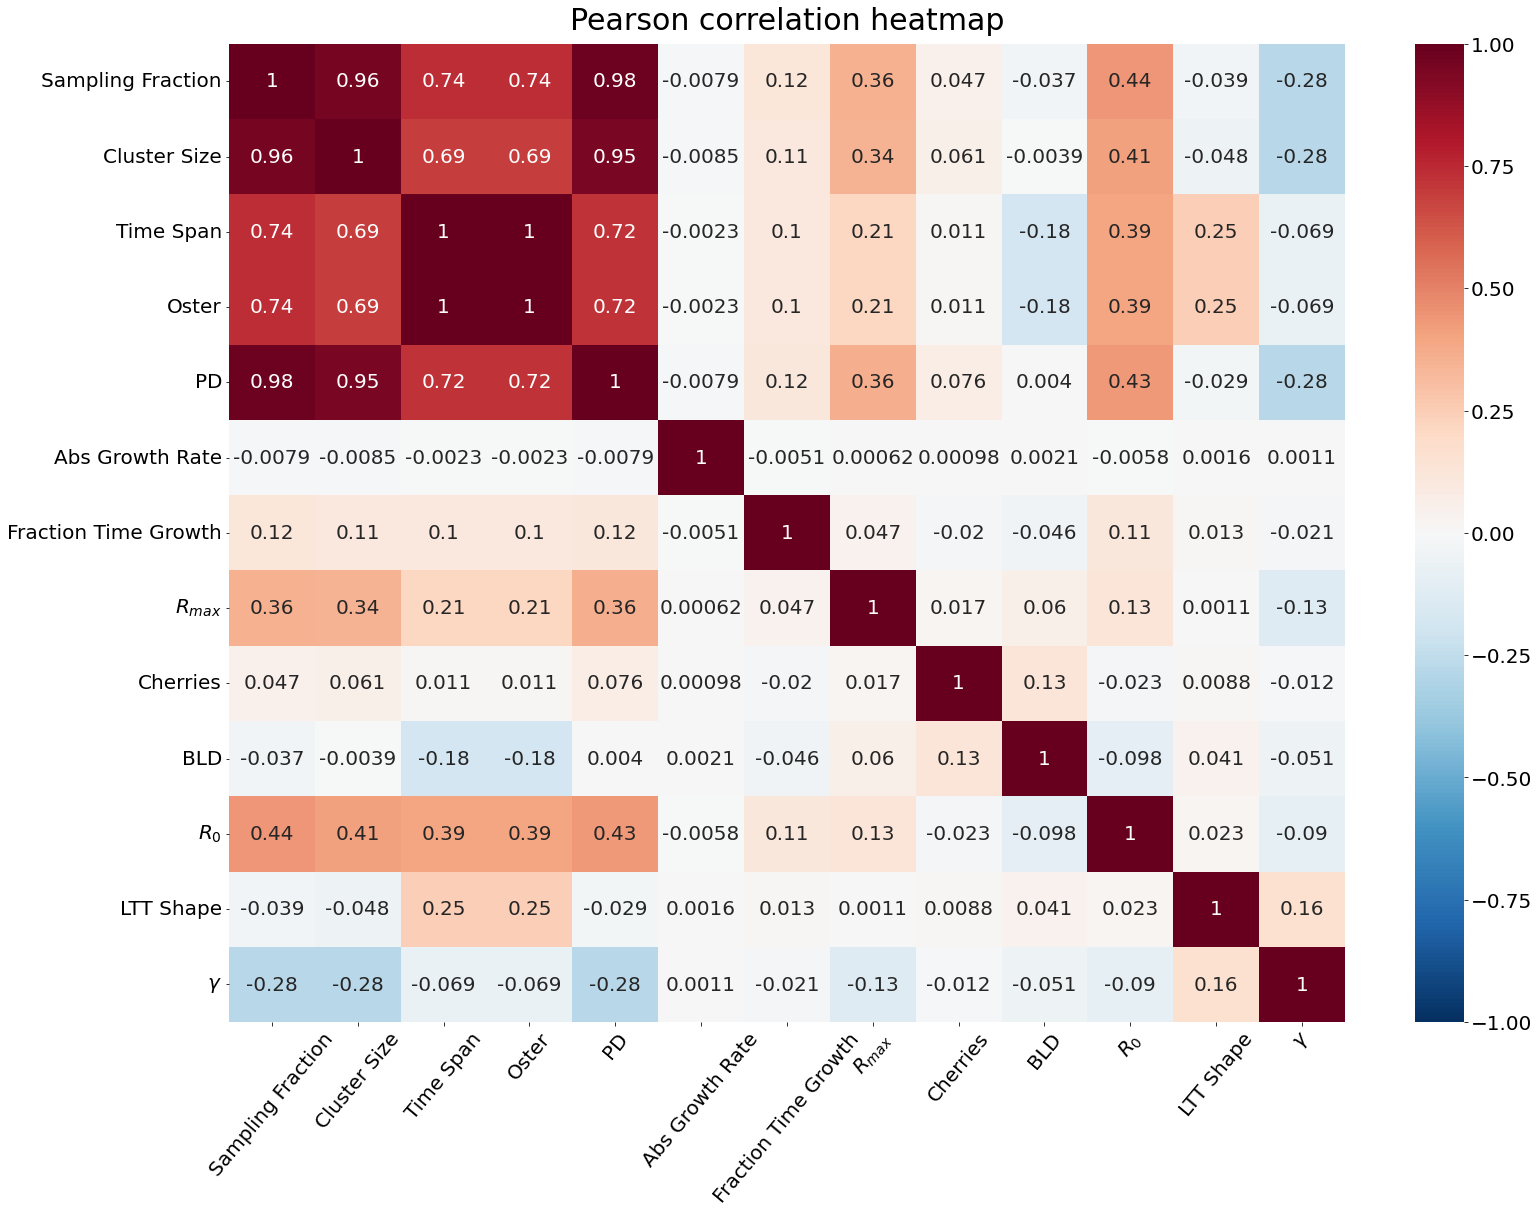

In [33]:
# Pearson Correlation Matrix

# Increase the size of the heatmap.
fig = plt.figure(figsize=(25, 18))
plt.rcParams.update({'font.size': 20})
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_df.corr(), vmin=-1, vmax=1, annot=True,cmap='RdBu_r')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Pearson correlation heatmap', fontdict={'fontsize':30}, pad=14);
heatmap.set_xticklabels(Paper_feat,rotation=50)
heatmap.set_yticklabels(Paper_feat)
#fig.savefig('../paper/pearson.svg',dpi=600,format='svg',bbox_inches='tight',pad_inches=0.0)

#### 1-2-2 Spearman correlation

In [34]:
# Compute pairwise correlation of columns (Spearman rank correlation, non-linear)
aly_df.corr("spearman")

,v_sampling_fraction,v_cluster_size,v_timespan,oster,PD,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,R0,ltt_shape_cat,gamma_cat
v_sampling_fraction,1.000000,0.985233,0.185657,0.185040,0.552794,0.416212,0.061815,0.422848,0.025523,0.031203,0.101747,-0.067941,-0.237321
v_cluster_size,0.985233,1.000000,0.172304,0.171691,0.542706,0.407904,0.056424,0.412831,0.031074,0.040084,0.095177,-0.069525,-0.233618
v_timespan,0.185657,0.172304,1.000000,0.999937,0.167327,-0.193241,0.073110,0.044354,-0.059150,-0.249627,0.135532,0.370181,0.052823
oster,0.185040,0.171691,0.999937,1.000000,0.169078,-0.190996,0.073164,0.046676,-0.060507,-0.248937,0.135329,0.367774,0.051900
PD,0.552794,0.542706,0.167327,0.169078,1.000000,0.487854,0.063422,0.495111,0.217870,0.172760,0.099668,-0.029574,-0.198947
abs_growth_rate,0.416212,0.407904,-0.193241,-0.190996,0.487854,1.000000,0.047662,0.853843,0.037016,0.238996,0.073772,-0.154357,-0.274243
fraction_time_growth,0.061815,0.056424,0.073110,0.073164,0.063422,0.047662,1.000000,0.072047,-0.024038,-0.030813,0.050708,0.010003,-0.020824
r_max,0.422848,0.412831,0.044354,0.046676,0.495111,0.853843,0.072047,1.000000,0.009914,0.174493,0.098747,-0.018978,-0.237107
cherries,0.025523,0.031074,-0.059150,-0.060507,0.217870,0.037016,-0.024038,0.009914,1.000000,0.114611,-0.019001,0.026816,0.009665
BLD,0.031203,0.040084,-0.249627,-0.248937,0.172760,0.238996,-0.030813,0.174493,0.114611,1.000000,-0.041054,0.053786,-0.055114


[Text(0, 0.5, 'Sampling Fraction'),
 Text(0, 1.5, 'Cluster Size'),
 Text(0, 2.5, 'Time Span'),
 Text(0, 3.5, 'Oster'),
 Text(0, 4.5, 'PD'),
 Text(0, 5.5, 'Abs Growth Rate'),
 Text(0, 6.5, 'Fraction Time Growth'),
 Text(0, 7.5, '$R_{max}$'),
 Text(0, 8.5, 'Cherries'),
 Text(0, 9.5, 'BLD'),
 Text(0, 10.5, '$R_0$'),
 Text(0, 11.5, 'LTT Shape'),
 Text(0, 12.5, '$\\gamma$')]

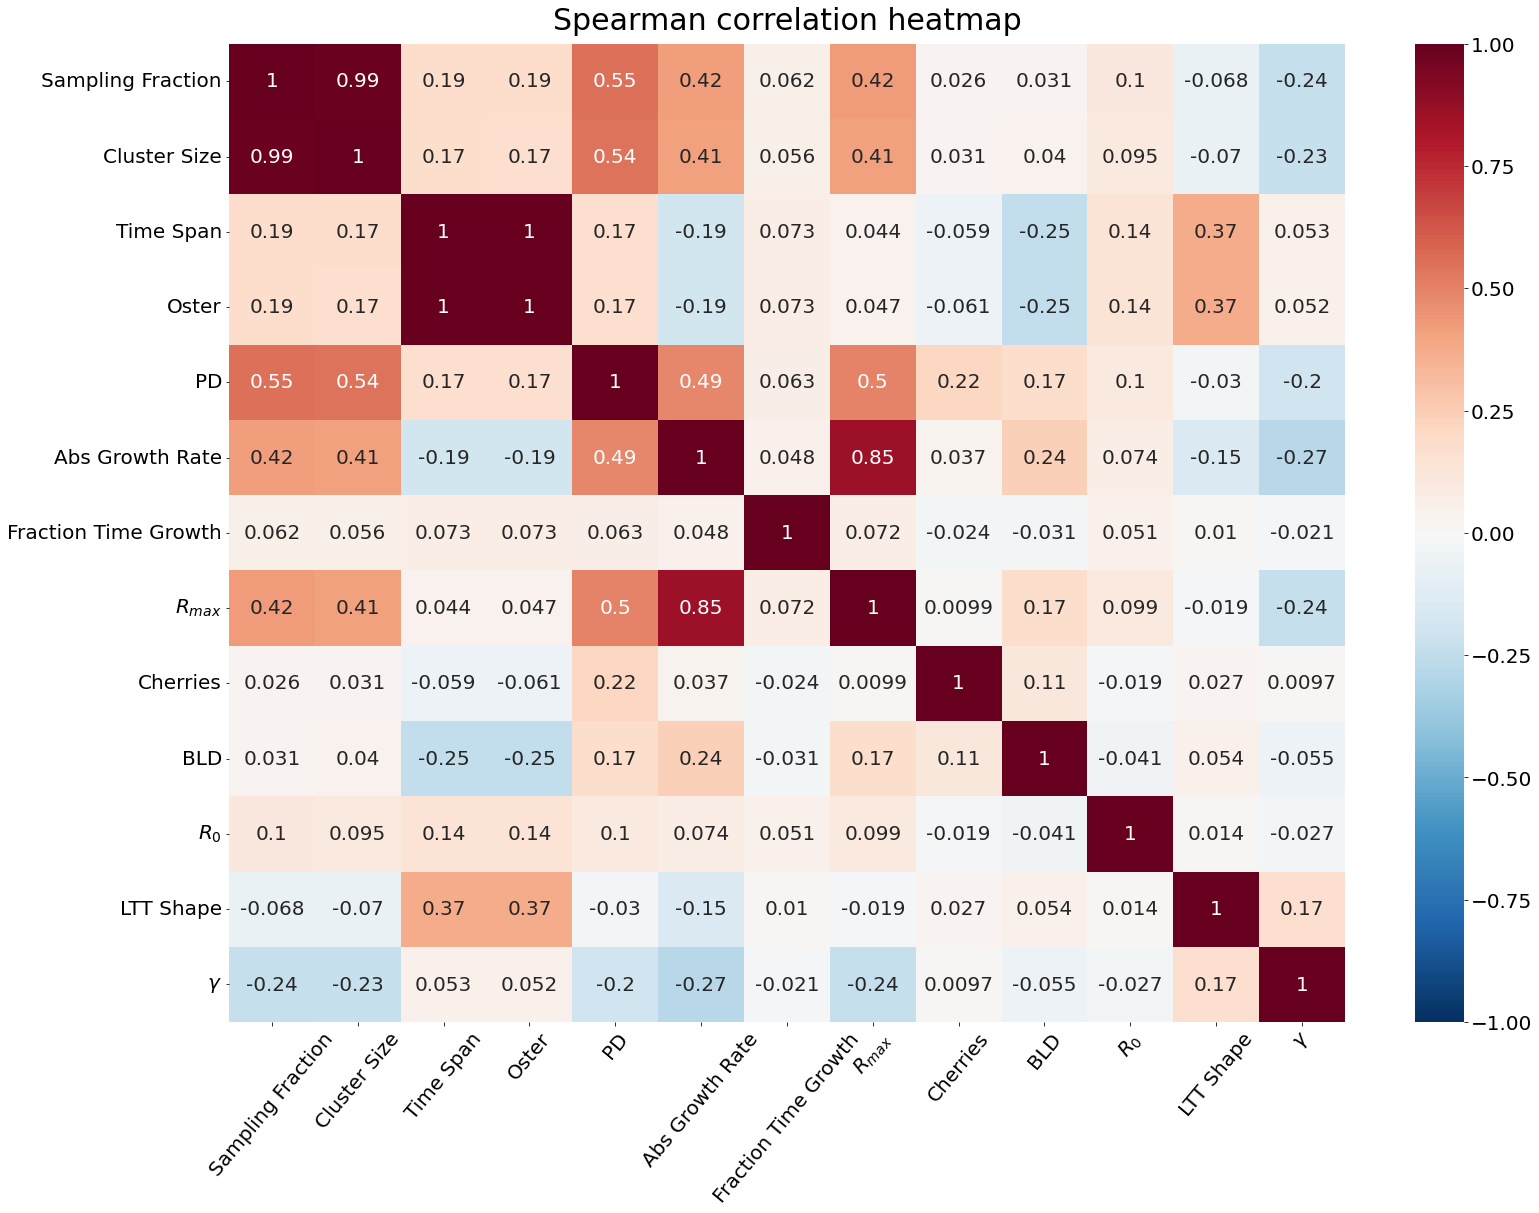

In [35]:
# Correlation Matrix

# Increase the size of the heatmap.
fig = plt.figure(figsize=(25, 18))
plt.rcParams.update({'font.size': 20})
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_df.corr('spearman'), vmin=-1, vmax=1, annot=True,cmap='RdBu_r')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Spearman correlation heatmap', fontdict={'fontsize':30}, pad=14);
heatmap.set_xticklabels(Paper_feat,rotation=50)
heatmap.set_yticklabels(Paper_feat)
#fig.savefig('../paper/spearman.svg',dpi=600,format='svg',bbox_inches='tight',pad_inches=0.0)

## Processing for Modeling

### Processing-1. One-hot encoding for the categorical feature
* ltt_shape_cat
* gamma_cat

In [36]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

cat_feat_cols = ['ltt_shape_cat','gamma_cat']
print(cat_feat_cols)
cat_onehot_feat = []
org_idx = node_df.index

for cat_feat in cat_feat_cols:
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    x = enc.fit_transform(node_df[cat_feat].values.reshape(-1, 1))
    n_dims = x.shape[-1]
    columns = [f'{cat_feat}_{i}' for i in range(n_dims)]
    cat_onehot_feat += columns
    cat_df = pd.DataFrame(x, index=org_idx, columns=columns)
    node_df = pd.concat([node_df, cat_df], axis=1)

['ltt_shape_cat', 'gamma_cat']


In [37]:
node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3
0,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,3.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-23,1.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-30,2.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,4.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,10000.0,Background,A,bg,0.000000,1630.56000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-03-09,7.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20678373,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-05,791.0,"(-20.742, inf]",2,2,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
20678374,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-17,991.0,"(-20.742, inf]",2,2,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
20678375,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-17,1139.0,"(-20.742, inf]",2,2,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
20678376,99.0,c3,E,decay,0.000345,0.49483,394.0,1.0,46.0,-16.378858,46.008649,224.0,2.300658,2.089202,0.045455,42.959823,convex,0.181818,3.0,2020-06-01,2925.0,"(-20.742, inf]",2,2,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Split the train/test sets (should put before imputing the missing values and calculating the correlation)

In [38]:
random_seed = 123
np.random.seed(random_seed)
split_dir = f'/mnt/data2/chaoyue/data/{ds_name}-classification/split_rs{random_seed}'
os.makedirs(split_dir, exist_ok=True)

In [39]:
from sklearn.model_selection import  train_test_split
#split the data for training and testing
train_ids, test_ids = train_test_split(tree_ids, test_size=0.2)
print(f"Train: {len(train_ids)}, Test: {len(test_ids)}")
print(test_ids[:10])

Train: 5138, Test: 1285
[3646. 9540. 5164. 1004. 8681. 4772. 4249. 4175. 3531. 4457.]


In [40]:

train_node_df = node_df[node_df['sim'].isin(train_ids)]
test_node_df = node_df[node_df['sim'].isin(test_ids)]

print(f'Train: {train_node_df.shape[0]}')
print(f'Test: {test_node_df.shape[0]}')
train_node_df.head()

Train: 16570271
Test: 4108107


,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3
0,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,3.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-23,1.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-30,2.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,4.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-03-09,7.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### Processing-2: R0 correction
* Use the mean value of positive R0 in the **training** to replace all the negative R0 in the training and test
* Normalize the R0

In [41]:
raw_r0 = np.reshape(train_node_df['R0'].values, (-1, 1))

# negtive replacement
r0_neg_idx = raw_r0 <= 0
r0_pos_idx = raw_r0 > 0
avg_r0 = np.average(raw_r0[r0_pos_idx])

raw_r0[r0_neg_idx] = avg_r0

In [42]:
prep_dict['r0'] = avg_r0

In [43]:
train_node_df['R0'].describe()

count    1.657027e+07
mean     1.866355e+00
std      9.344003e-01
min      6.305921e-04
25%      1.359053e+00
50%      1.866355e+00
75%      2.190019e+00
max      8.187527e+00
Name: R0, dtype: float64

In [44]:
r0_norm_col = 'new_R0'
train_node_df[r0_norm_col]=raw_r0
train_node_df[r0_norm_col].describe()

/home/chaoyue/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


count    1.657027e+07
mean     1.866355e+00
std      9.344003e-01
min      6.305921e-04
25%      1.359053e+00
50%      1.866355e+00
75%      2.190019e+00
max      8.187527e+00
Name: new_R0, dtype: float64

In [45]:
test_node_df['R0'].describe()

count    4.108107e+06
mean    -2.055769e-02
std      3.991921e+00
min     -6.549541e+01
25%     -7.894241e-01
50%      8.356423e-01
75%      2.149310e+00
max      8.053442e+00
Name: R0, dtype: float64

In [46]:
raw_r0 = np.reshape(test_node_df['R0'].values, (-1, 1))
r0_neg_idx = raw_r0 <= 0
raw_r0[r0_neg_idx] = avg_r0

In [47]:
r0_norm_col = 'new_R0'
test_node_df[r0_norm_col]=raw_r0
test_node_df[r0_norm_col].describe()

count    4.108107e+06
mean     1.864745e+00
std      9.028944e-01
min      1.922004e-03
25%      1.443399e+00
50%      1.866355e+00
75%      2.149310e+00
max      8.053442e+00
Name: new_R0, dtype: float64

In [48]:
num_feat_cols[-1] = 'new_R0'

### Processing-3. Normalize the input features:
* Use Standardization
* Use MinMax normalization to normalize data to [0, 1]

array([[<AxesSubplot:title={'center':'v_sampling_fraction'}>,
        <AxesSubplot:title={'center':'v_cluster_size'}>,
        <AxesSubplot:title={'center':'v_timespan'}>],
       [<AxesSubplot:title={'center':'oster'}>,
        <AxesSubplot:title={'center':'PD'}>,
        <AxesSubplot:title={'center':'abs_growth_rate'}>],
       [<AxesSubplot:title={'center':'fraction_time_growth'}>,
        <AxesSubplot:title={'center':'r_max'}>,
        <AxesSubplot:title={'center':'cherries'}>],
       [<AxesSubplot:title={'center':'BLD'}>,
        <AxesSubplot:title={'center':'new_R0'}>, <AxesSubplot:>]],
      dtype=object)

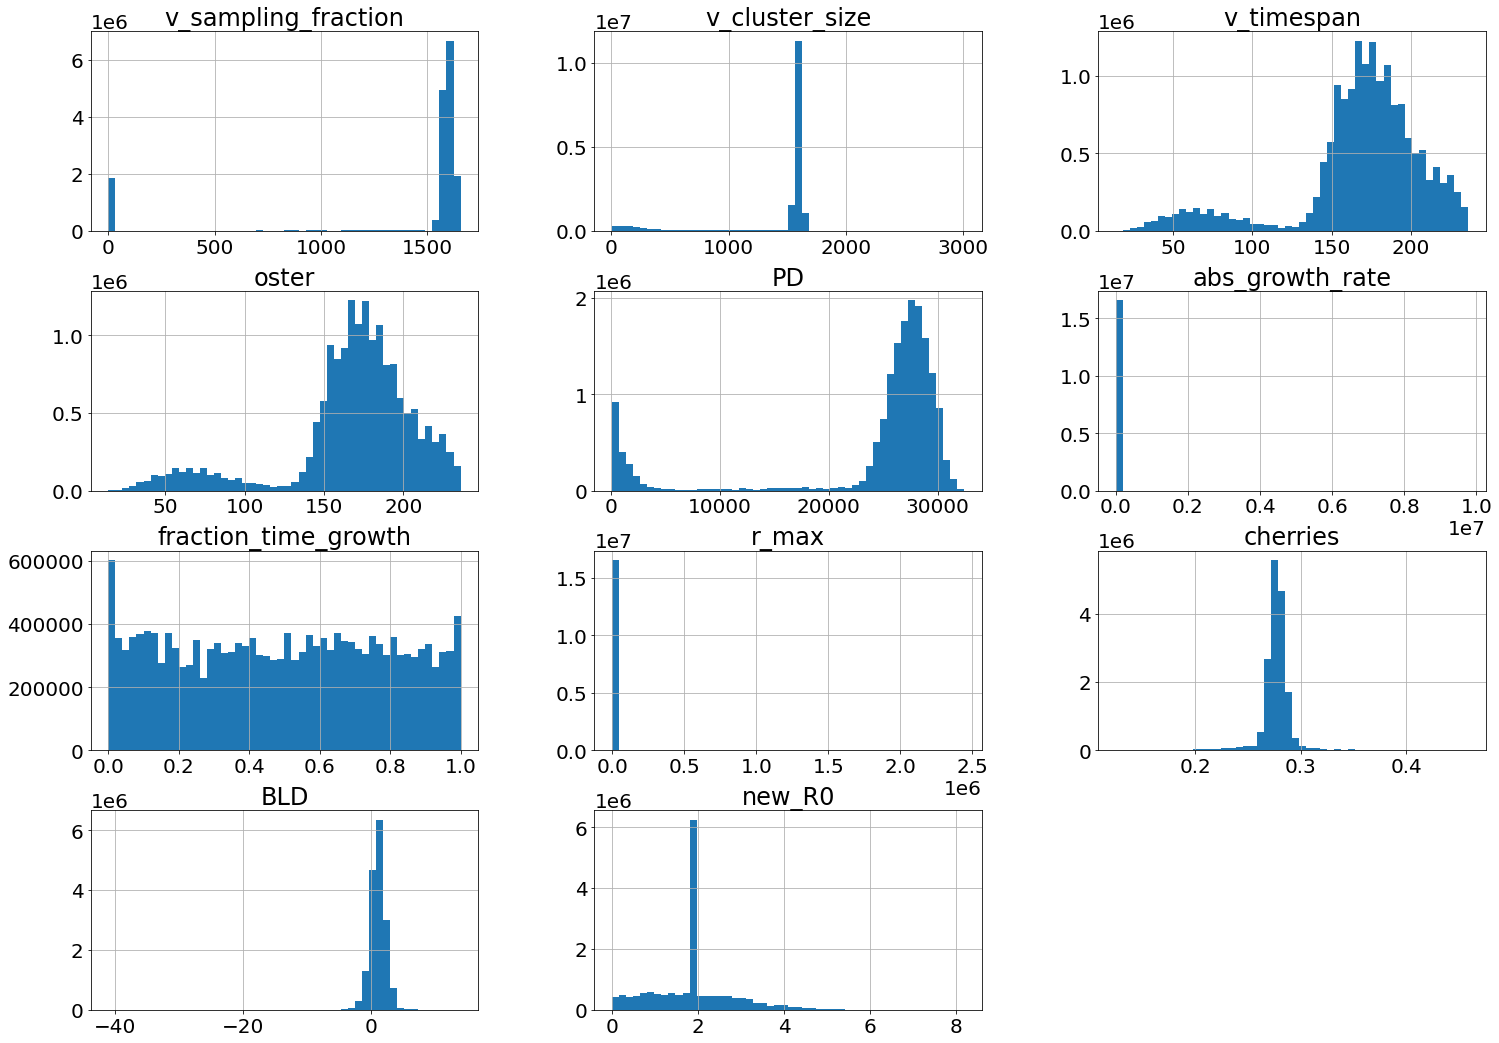

In [49]:
train_node_df[num_feat_cols].hist(bins=50,figsize=(25, 18))

In [50]:
num_feat_cols

['v_sampling_fraction',
 'v_cluster_size',
 'v_timespan',
 'oster',
 'PD',
 'abs_growth_rate',
 'fraction_time_growth',
 'r_max',
 'cherries',
 'BLD',
 'new_R0']

In [51]:
cat_feat_cols

['ltt_shape_cat', 'gamma_cat']

In [52]:
feat_cols = num_feat_cols+cat_feat_cols
feat_cols

['v_sampling_fraction',
 'v_cluster_size',
 'v_timespan',
 'oster',
 'PD',
 'abs_growth_rate',
 'fraction_time_growth',
 'r_max',
 'cherries',
 'BLD',
 'new_R0',
 'ltt_shape_cat',
 'gamma_cat']

In [53]:
# Standardization non-category features
std_scaler = preprocessing.StandardScaler().fit(train_node_df[num_feat_cols])
norm_num_feat_cols = [f'{col_name}-norm' for col_name in num_feat_cols]
norm_train_vals = std_scaler.transform(train_node_df[num_feat_cols])
norm_train_node_df = pd.DataFrame(norm_train_vals, columns=norm_num_feat_cols, index=train_node_df.index)
train_node_df = pd.concat([train_node_df, norm_train_node_df], axis=1)

In [54]:
norm_train_vals

array([[ 0.46444599,  0.46458804,  0.78142049, ...,  0.29241692,
         0.14277934, -1.73473   ],
       [ 0.46444599,  0.46458804,  0.78142049, ...,  0.29241692,
         0.14277934, -1.73473   ],
       [ 0.46444599,  0.46458804,  0.78142049, ...,  0.29241692,
         0.14277934, -1.73473   ],
       ...,
       [-2.69294868, -2.68670285, -2.8650722 , ..., -0.31147298,
         1.40739119, -1.28067535],
       [-2.69294868, -2.68670285, -2.8650722 , ..., -0.31147298,
         1.40739119, -1.28067535],
       [-2.69294868, -2.68670285, -2.8650722 , ..., -0.31147298,
         1.40739119, -1.28067535]])

array([[<AxesSubplot:title={'center':'v_sampling_fraction-norm'}>,
        <AxesSubplot:title={'center':'v_cluster_size-norm'}>,
        <AxesSubplot:title={'center':'v_timespan-norm'}>],
       [<AxesSubplot:title={'center':'oster-norm'}>,
        <AxesSubplot:title={'center':'PD-norm'}>,
        <AxesSubplot:title={'center':'abs_growth_rate-norm'}>],
       [<AxesSubplot:title={'center':'fraction_time_growth-norm'}>,
        <AxesSubplot:title={'center':'r_max-norm'}>,
        <AxesSubplot:title={'center':'cherries-norm'}>],
       [<AxesSubplot:title={'center':'BLD-norm'}>,
        <AxesSubplot:title={'center':'new_R0-norm'}>, <AxesSubplot:>]],
      dtype=object)

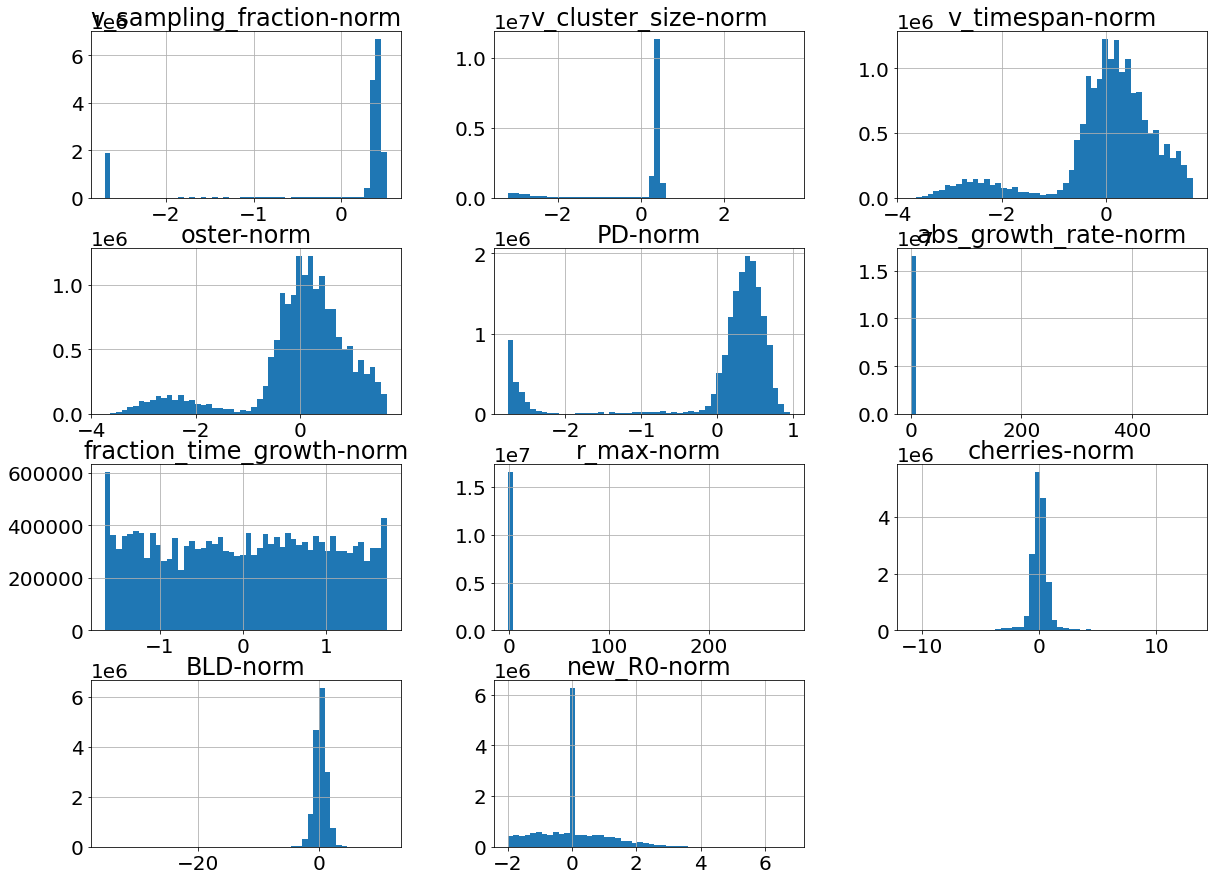

In [55]:
train_node_df[norm_num_feat_cols].hist(bins=50,figsize=(20,15))

In [56]:
print(std_scaler.mean_, std_scaler.scale_)

[1.39074945e+03 1.42492786e+03 1.67855942e+02 1.67858146e+02
 2.41334732e+04 2.05382415e+02 4.90869067e-01 8.17149881e+03
 2.77034274e-01 8.30644472e-01 1.86635466e+00] [5.16336783e+02 4.41406410e+02 4.11354177e+01 4.11340343e+01
 8.70478721e+03 1.91780659e+04 2.95821827e-01 8.67388604e+03
 1.38278487e-02 1.18613470e+00 9.34400315e-01]


In [57]:
norm_test_vals = std_scaler.transform(test_node_df[num_feat_cols])
norm_test_node_df = pd.DataFrame(norm_test_vals, columns=norm_num_feat_cols, index=test_node_df.index)
test_node_df = pd.concat([test_node_df, norm_test_node_df], axis=1)

array([[<AxesSubplot:title={'center':'v_sampling_fraction-norm'}>,
        <AxesSubplot:title={'center':'v_cluster_size-norm'}>,
        <AxesSubplot:title={'center':'v_timespan-norm'}>],
       [<AxesSubplot:title={'center':'oster-norm'}>,
        <AxesSubplot:title={'center':'PD-norm'}>,
        <AxesSubplot:title={'center':'abs_growth_rate-norm'}>],
       [<AxesSubplot:title={'center':'fraction_time_growth-norm'}>,
        <AxesSubplot:title={'center':'r_max-norm'}>,
        <AxesSubplot:title={'center':'cherries-norm'}>],
       [<AxesSubplot:title={'center':'BLD-norm'}>,
        <AxesSubplot:title={'center':'new_R0-norm'}>, <AxesSubplot:>]],
      dtype=object)

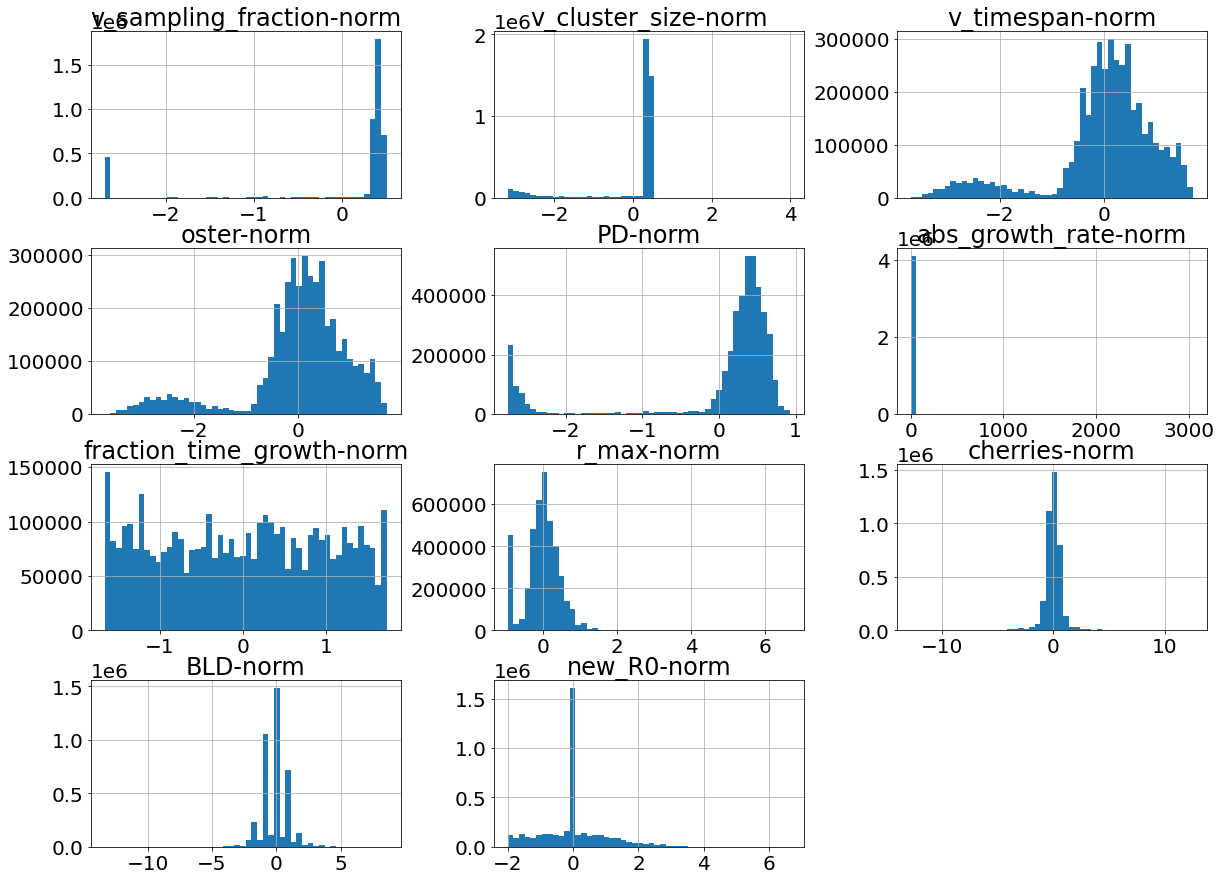

In [58]:
test_node_df[norm_num_feat_cols].hist(bins=50,figsize=(20,15))

In [59]:
train_node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
0,10000.0,Background,A,bg,0.0,1630.560000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,3.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.781420,0.781429,0.209945,-0.003340,-0.020352,-0.058523,0.292417,0.142779,-1.734730
1,10000.0,Background,A,bg,0.0,1630.560000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-23,1.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.781420,0.781429,0.209945,-0.003340,-0.020352,-0.058523,0.292417,0.142779,-1.734730
2,10000.0,Background,A,bg,0.0,1630.560000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-30,2.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.781420,0.781429,0.209945,-0.003340,-0.020352,-0.058523,0.292417,0.142779,-1.734730
3,10000.0,Background,A,bg,0.0,1630.560000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,4.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.781420,0.781429,0.209945,-0.003340,-0.020352,-0.058523,0.292417,0.142779,-1.734730
4,10000.0,Background,A,bg,0.0,1630.560000,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-03-09,7.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.781420,0.781429,0.209945,-0.003340,-0.020352,-0.058523,0.292417,0.142779,-1.734730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20671658,9997.0,c3,C,static,0.0,0.280994,239.0,1.0,50.0,-1.849934,50.006967,619.0,0.669691,5.048853,0.125000,97.766724,convex,0.272727,2.5,2020-07-15,715.0,"(-20.742, inf]",2,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.669691,-2.692949,-2.686703,-2.865072,-2.865053,-2.701327,-0.010446,-1.236789,-0.930809,-0.311473,1.407391,-1.280675
20671659,9997.0,c3,C,static,0.0,0.280994,239.0,1.0,50.0,-1.849934,50.006967,619.0,0.669691,5.048853,0.125000,97.766724,convex,0.272727,2.5,2020-06-27,427.0,"(-20.742, inf]",2,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.669691,-2.692949,-2.686703,-2.865072,-2.865053,-2.701327,-0.010446,-1.236789,-0.930809,-0.311473,1.407391,-1.280675
20671660,9997.0,c3,C,static,0.0,0.280994,239.0,1.0,50.0,-1.849934,50.006967,619.0,0.669691,5.048853,0.125000,97.766724,convex,0.272727,2.5,2020-07-27,2746.0,"(-20.742, inf]",2,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.669691,-2.692949,-2.686703,-2.865072,-2.865053,-2.701327,-0.010446,-1.236789,-0.930809,-0.311473,1.407391,-1.280675
20671661,9997.0,c3,C,static,0.0,0.280994,239.0,1.0,50.0,-1.849934,50.006967,619.0,0.669691,5.048853,0.125000,97.766724,convex,0.272727,2.5,2020-07-24,2745.0,"(-20.742, inf]",2,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.669691,-2.692949,-2.686703,-2.865072,-2.865053,-2.701327,-0.010446,-1.236789,-0.930809,-0.311473,1.407391,-1.280675


In [60]:
num_feat_cols

['v_sampling_fraction',
 'v_cluster_size',
 'v_timespan',
 'oster',
 'PD',
 'abs_growth_rate',
 'fraction_time_growth',
 'r_max',
 'cherries',
 'BLD',
 'new_R0']

In [61]:
prep_dict['feat'] = num_feat_cols
prep_dict['mean'] = std_scaler.mean_
prep_dict['std'] = std_scaler.scale_
prep_dict

{'gamma_bins': array([-14440.1413306 ,   -103.50127832,    -90.34677623,    -20.74197748,
                    inf]),
 'gamma_cat_dict': {Interval(-103.501, -90.347, closed='right'): 0,
  Interval(-14440.142, -103.501, closed='right'): 1,
  Interval(-20.742, inf, closed='right'): 2,
  Interval(-90.347, -20.742, closed='right'): 3},
 'ltt_shape': {0: 'concave',
  1: 'concave_convex',
  2: 'convex',
  3: 'convex_concave'},
 'gamma': {0: "(-103.501, -90.347, 'right')",
  1: "(-14440.142, -103.501, 'right')",
  2: "(-20.742, inf, 'right')",
  3: "(-90.347, -20.742, 'right')"},
 'dynamic': {0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'},
 'r0': 1.8663546645050366,
 'feat': ['v_sampling_fraction',
  'v_cluster_size',
  'v_timespan',
  'oster',
  'PD',
  'abs_growth_rate',
  'fraction_time_growth',
  'r_max',
  'cherries',
  'BLD',
  'new_R0'],
 'mean': array([1.39074945e+03, 1.42492786e+03, 1.67855942e+02, 1.67858146e+02,
        2.41334732e+04, 2.05382415e+02, 4.90869067e-01, 8.17149881e+03,

In [62]:
np.save("prep-TB.npy",prep_dict)

#### Plot for Paper Supplementary(not included in preprocessing) 

In [89]:
# remove samples with AbsGrowth Rate>100
train_node_df = train_node_df[train_node_df[feat_cols[5]]<100]
test_node_df = test_node_df[test_node_df[feat_cols[5]]<100]

D:\Downloads\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


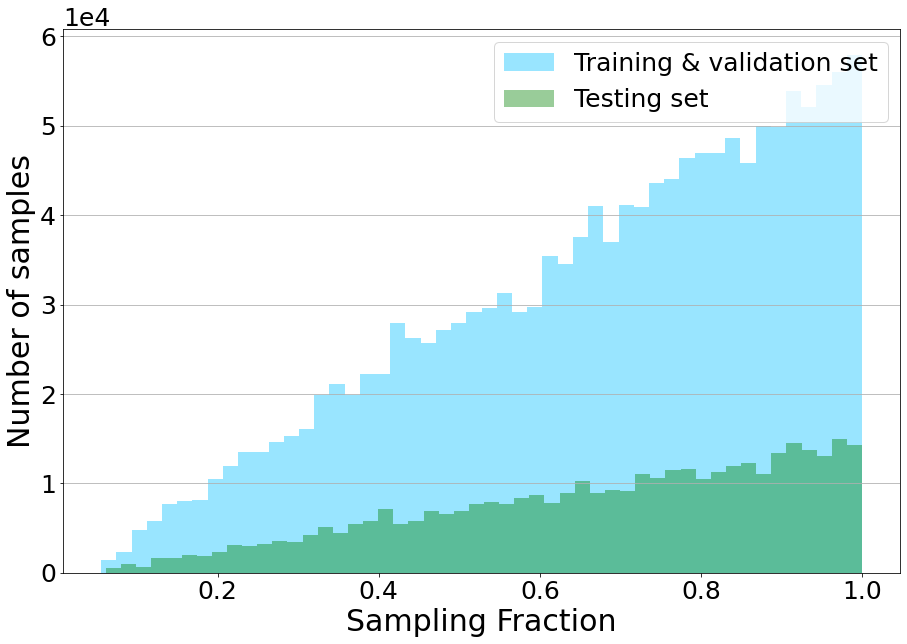

In [90]:
i = 0
feat = feat_cols[i]
#for feat in feat_cols:
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_node_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_node_df[feat],hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,700000))
ax1.axes.set_ylabel("Number of samples",fontsize=30)
ax1.axes.set_xlabel(f"{Paper_feat[i]}",fontsize=30)
#ax1.axes.set_xlabel(f"{Paper_feat[i]} category",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
#fig.savefig(f"../paper/feat_dist/{feat}.svg",bbox_inches='tight',pad_inches=0.0,dpi=600,format='svg')

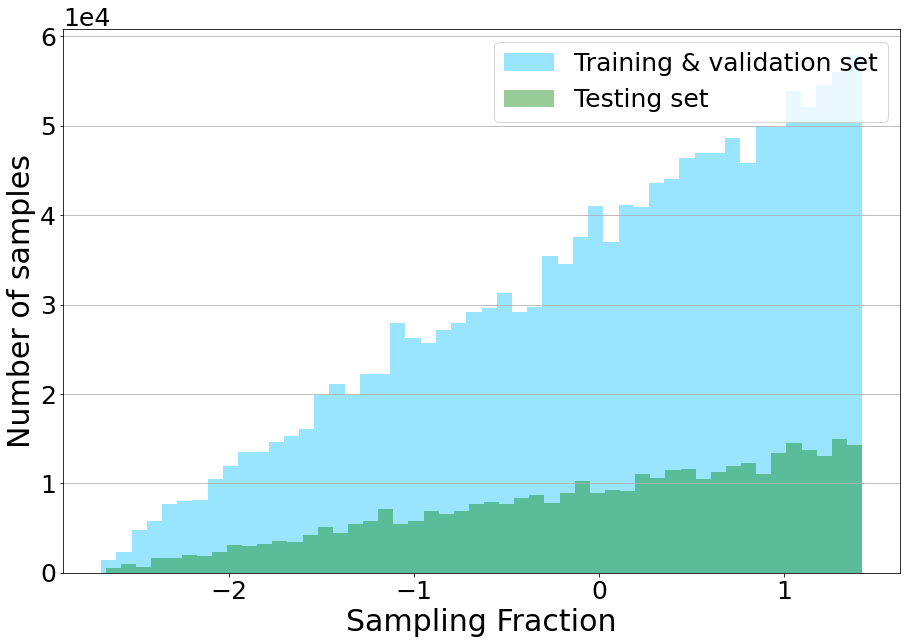

In [91]:
i = 0
feat = norm_num_feat_cols[i]
#for feat in feat_cols:
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_node_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_node_df[feat],hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,1800000))
ax1.axes.set_ylabel("Number of samples",fontsize=30)
ax1.axes.set_xlabel(f"{Paper_feat[i]}",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
#fig.savefig(f"../paper/norm_feat_dist/{feat}.svg",bbox_inches='tight',pad_inches=0.0,dpi=600,format='svg')

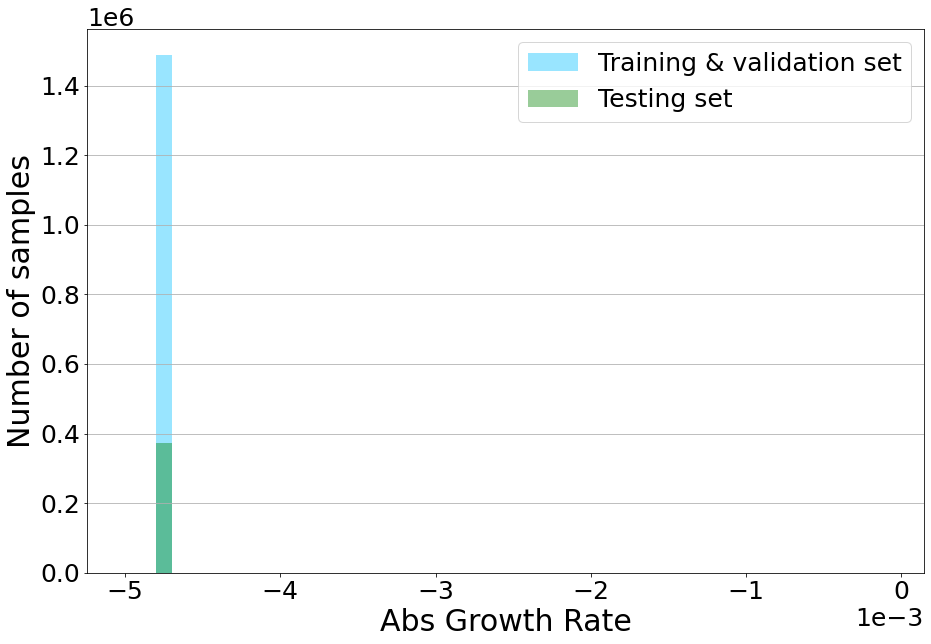

In [92]:
# special for AbsGrowthRate
i = 5
feat = norm_num_feat_cols[i]
#for feat in feat_cols:
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_node_df[feat],bins=np.arange(-0.005,0,0.0001),hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_node_df[feat],bins=np.arange(-0.005,0,0.0001),hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,1800000))
ax1.axes.set_ylabel("Number of samples",fontsize=30)
ax1.axes.set_xlabel(f"{Paper_feat[i]}",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
#fig.savefig(f"../paper/norm_feat_dist/{feat}.svg",bbox_inches='tight',pad_inches=0.0,dpi=600,format='svg')

In [63]:
# Obtain the onehot features
import re
all_cols = node_df.columns.values

onehot_cols = []
for feat_name, pattern in zip(['ltt_shape_onehot', 'R0_onehot', 'gamma_onehot'], 
                              ['ltt_shape_cat_\d*', 'R0_cat_\d*', 'gamma_cat_\d']):
    for feat_col in all_cols:
        m = re.match(pattern, feat_col)
        if m:
            feat_dict.setdefault(feat_name, []).append(m.group(0))
            
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'gamma': {0: "(-103.501, -90.347, 'right')", 1: "(-14440.142, -103.501, 'right')", 2: "(-20.742, inf, 'right')", 3: "(-90.347, -20.742, 'right')"}, 'dynamic': {0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}, 'ltt_shape_onehot': ['ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3'], 'gamma_onehot': ['gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']}


In [64]:
print(train_node_df.shape)

(16570271, 45)


In [65]:
train_node_df.head()

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
0,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,3.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
1,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-23,1.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
2,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-30,2.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
3,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,4.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
4,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-03-09,7.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473


In [66]:
train_node_df.head()

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
0,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,3.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
1,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-23,1.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
2,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-30,2.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
3,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,4.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
4,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-03-09,7.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473


### Merge the background and non-background nodes

In [67]:
# train_full_df = train_node_df.merge(train_background_df, how='inner', left_on=list(train_background_df.columns), right_on=list(train_background_df.columns), left_index=True, right_index=True)
#train_full_df = train_node_df
#print(f'Train: {train_full_df.shape}')

#test_full_df = test_node_df
#print(f'Test: {test_full_df.shape}')

train_full_df = train_node_df
print(f'Train: {train_full_df.shape}')

test_full_df = test_node_df
print(f'Test: {test_full_df.shape}')

Train: (16570271, 45)
Test: (4108107, 45)


#### Split validation set

In [68]:
train_ids, valid_ids = train_test_split(train_ids, test_size=0.25)
print(f"Train: {len(train_ids)}, Test: {len(valid_ids)}")
print(valid_ids[:10])

Train: 3853, Test: 1285
[7606. 2764. 3664. 4749. 6504. 7770.   70. 9559. 1131. 8361.]


In [69]:
train_full_df = train_full_df.reset_index(drop=True)
train_node_df = train_full_df[train_full_df['sim'].isin(train_ids)]
valid_node_df = train_full_df[train_full_df['sim'].isin(valid_ids)]

print(f'Train node: {train_node_df.shape[0]}')
print(f'Valid node: {valid_node_df.shape[0]}')
train_node_df.head()

Train node: 12417897
Valid node: 4152374


,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
0,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,3.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
1,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-23,1.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
2,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-30,2.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
3,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,4.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
4,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-03-09,7.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473


In [70]:
# Save the train/valid/test to the disk
train_node_df.to_csv(f'{split_dir}/train.csv', index=False)
test_full_df.to_csv(f'{split_dir}/test.csv', index=False)
valid_node_df.to_csv(f'{split_dir}/valid.csv', index=False)

In [71]:
train_full_df.head()

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
0,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,3.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
1,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-23,1.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
2,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-01-30,2.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
3,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-02-04,4.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473
4,10000.0,Background,A,bg,0.0,1630.56,1630.0,1.0,200.0,-92.407847,200.001471,25961.0,0.245422,141.319483,0.484848,7663.879785,convex_concave,0.281078,1.0,2020-03-09,7.0,"(-103.501, -90.347]",0,3,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.245422,0.464446,0.464588,0.78142,0.781429,0.209945,-0.00334,-0.020352,-0.058523,0.292417,0.142779,-1.73473


In [72]:
train_full_df.tail()

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
16570266,9997.0,c3,C,static,0.0,0.280994,239.0,1.0,50.0,-1.849934,50.006967,619.0,0.669691,5.048853,0.125,97.766724,convex,0.272727,2.5,2020-07-15,715.0,"(-20.742, inf]",2,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.669691,-2.692949,-2.686703,-2.865072,-2.865053,-2.701327,-0.010446,-1.236789,-0.930809,-0.311473,1.407391,-1.280675
16570267,9997.0,c3,C,static,0.0,0.280994,239.0,1.0,50.0,-1.849934,50.006967,619.0,0.669691,5.048853,0.125,97.766724,convex,0.272727,2.5,2020-06-27,427.0,"(-20.742, inf]",2,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.669691,-2.692949,-2.686703,-2.865072,-2.865053,-2.701327,-0.010446,-1.236789,-0.930809,-0.311473,1.407391,-1.280675
16570268,9997.0,c3,C,static,0.0,0.280994,239.0,1.0,50.0,-1.849934,50.006967,619.0,0.669691,5.048853,0.125,97.766724,convex,0.272727,2.5,2020-07-27,2746.0,"(-20.742, inf]",2,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.669691,-2.692949,-2.686703,-2.865072,-2.865053,-2.701327,-0.010446,-1.236789,-0.930809,-0.311473,1.407391,-1.280675
16570269,9997.0,c3,C,static,0.0,0.280994,239.0,1.0,50.0,-1.849934,50.006967,619.0,0.669691,5.048853,0.125,97.766724,convex,0.272727,2.5,2020-07-24,2745.0,"(-20.742, inf]",2,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.669691,-2.692949,-2.686703,-2.865072,-2.865053,-2.701327,-0.010446,-1.236789,-0.930809,-0.311473,1.407391,-1.280675
16570270,9997.0,c3,C,static,0.0,0.280994,239.0,1.0,50.0,-1.849934,50.006967,619.0,0.669691,5.048853,0.125,97.766724,convex,0.272727,2.5,2020-07-22,2744.0,"(-20.742, inf]",2,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.669691,-2.692949,-2.686703,-2.865072,-2.865053,-2.701327,-0.010446,-1.236789,-0.930809,-0.311473,1.407391,-1.280675


### Finalize the feature information and save to the file

In [73]:
all_cols = test_full_df.columns
print(all_cols)

Index(['sim', 'cluster_id', 'state', 'dynamic', 'dynamic_rparam',
       'v_sampling_fraction', 'v_cluster_size', 'v_fraction_state',
       'v_timespan', 'gamma', 'oster', 'PD', 'R0', 'abs_growth_rate',
       'fraction_time_growth', 'r_max', 'ltt_shape', 'cherries', 'BLD', 'date',
       'node', 'gamma_bin', 'gamma_cat', 'ltt_shape_cat', 'dynamic_cat',
       'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2',
       'ltt_shape_cat_3', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2',
       'gamma_cat_3', 'new_R0', 'v_sampling_fraction-norm',
       'v_cluster_size-norm', 'v_timespan-norm', 'oster-norm', 'PD-norm',
       'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm',
       'cherries-norm', 'BLD-norm', 'new_R0-norm'],
      dtype='object')


In [74]:
onehot_cols = feat_dict['ltt_shape_onehot'] + feat_dict['gamma_onehot']

raw_cols = num_feat_cols + cat_feat_cols
norm_onehot_cols = norm_num_feat_cols + onehot_cols
print(f'Raw cols: {raw_cols}', len(raw_cols))
print(f'Norm with onehot cols: {norm_onehot_cols[3:]}', len(norm_onehot_cols[3:]))

Raw cols: ['v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'oster', 'PD', 'abs_growth_rate', 'fraction_time_growth', 'r_max', 'cherries', 'BLD', 'new_R0', 'ltt_shape_cat', 'gamma_cat'] 13
Norm with onehot cols: ['oster-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm', 'new_R0-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3'] 16


In [75]:
feat_dict['raw_feats'] = raw_cols
feat_dict['norm_onehot_feats'] = norm_onehot_cols[3:]

In [76]:
import json 

with open('feat_dict-TB.json', 'w') as outfile:
    json.dump(feat_dict, outfile, sort_keys=True, indent=4)